# PROJECTE FINAL: Predicció de la temperatura mitjana i dels dies de pluja.

Resumen:

- Regresión:
datos --> datos descargados de la web de AEMET
datos_modelo --> datos para preparar el modelo utilizando únicamente las columnas numéricas y eliminando los valores nulos


In [1]:
# Unir els fixters json amb totes les dades meteorologiques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, re
import datetime
from datetime import datetime
import time

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Unifiquem els fitxter json descarregats des de Aemet
path = 'C:/RAUL/NISSAN/GENERAL/USB/FORMACION/BootCamp - Data Scientist_Analist/IT Academy Cibernarium - Data Science/Data Science Itinerario/11.- Proyecto Final/datos/'
filelist = os.listdir(path) 
list = []
datos = pd.DataFrame()
for file in filelist:
    df2 = pd.read_json(path+file, convert_axes=True)
    date_name = file[:-5]
    df2['Lustro'] = date_name
    list.append(df2)
datos = pd.concat(list)

datos['prec'].replace('Ip', '0,05', inplace=True) # forcem les precipitacions molt petites a valor 0.05
datos =datos.replace(to_replace=",", value=".", regex=True) # canviem els punts per les comes als decimals

# cambiem el tipus de les referències numèriques
cols=['prec', 'tmed', 'tmin', 'tmax', 'sol', 'velmedia', 'racha', 'presMin', 'presMax']
for col in cols:
     datos[col] = datos[col].astype('float64', errors='ignore')

# desglosem anys i mesos perqué podrien tenir relació amb la temperatura        
datos['año']=pd.DatetimeIndex(datos['fecha']).year
datos['mes']=pd.DatetimeIndex(datos['fecha']).month

# datos = datos[datos['tmed'].notna()]

In [3]:
datos.shape

(26620, 23)

In [4]:
datos.isnull().sum()

fecha             0
indicativo        0
nombre            0
provincia         0
altitud           0
tmed             70
prec            102
tmin             69
tmax             68
horatmin        956
horatmax        973
sol            2187
Lustro            0
dir            5329
velmedia       4143
racha          5331
horaracha      5356
presMax        4207
horaPresMax    4209
presMin        4300
horaPresMin    4303
año               0
mes               0
dtype: int64

In [5]:
datos.reset_index(drop=True, inplace=True) 
datos.head()

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,tmax,horatmin,...,dir,velmedia,racha,horaracha,presMax,horaPresMax,presMin,horaPresMin,año,mes
0,1950-01-01,76,BARCELONA AEROPUERTO,BARCELONA,4,10.5,0.0,7.5,13.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1
1,1950-01-02,76,BARCELONA AEROPUERTO,BARCELONA,4,9.0,0.0,4.0,13.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1
2,1950-01-03,76,BARCELONA AEROPUERTO,BARCELONA,4,7.5,0.0,1.0,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1
3,1950-01-04,76,BARCELONA AEROPUERTO,BARCELONA,4,7.9,0.0,0.8,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1
4,1950-01-05,76,BARCELONA AEROPUERTO,BARCELONA,4,10.8,0.0,5.0,16.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950,1


In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26620 entries, 0 to 26619
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        26620 non-null  object 
 1   indicativo   26620 non-null  int64  
 2   nombre       26620 non-null  object 
 3   provincia    26620 non-null  object 
 4   altitud      26620 non-null  int64  
 5   tmed         26550 non-null  float64
 6   prec         26518 non-null  float64
 7   tmin         26551 non-null  float64
 8   tmax         26552 non-null  float64
 9   horatmin     25664 non-null  object 
 10  horatmax     25647 non-null  object 
 11  sol          24433 non-null  float64
 12  Lustro       26620 non-null  object 
 13  dir          21291 non-null  float64
 14  velmedia     22477 non-null  float64
 15  racha        21289 non-null  float64
 16  horaracha    21264 non-null  object 
 17  presMax      22413 non-null  float64
 18  horaPresMax  22411 non-null  object 
 19  pres

In [7]:
Fechalreves=str(datetime.now().year) + str(datetime.now().month)+ str(datetime.now().day)
datos.to_excel("Prueba datos climatológicos aeropuerto de Barcelona-"+Fechalreves+".xlsx")

In [8]:
datos.describe().round(2)

,indicativo,altitud,tmed,prec,tmin,tmax,sol,dir,velmedia,racha,presMax,presMin,año,mes
count,26620.0,26620.0,26550.00,26518.00,26551.00,26552.00,24433.00,21291.0,22477.00,21289.00,22413.00,22320.00,26620.00,26620.00
mean,76.0,4.0,16.02,1.66,11.80,20.24,6.76,30.2,4.04,9.77,1018.38,1014.00,1985.95,6.51
std,0.0,0.0,5.83,7.11,6.09,5.80,3.78,25.9,1.71,3.22,6.31,7.17,21.04,3.44
min,76.0,4.0,-4.00,0.00,-8.00,0.00,0.00,0.0,0.00,0.00,989.90,974.10,1950.00,1.00
25%,76.0,4.0,11.20,0.00,7.00,15.50,3.90,15.0,3.10,7.80,1014.80,1010.00,1968.00,4.00
50%,76.0,4.0,15.50,0.00,11.40,19.80,7.40,23.0,3.90,9.20,1018.30,1014.50,1986.00,7.00
75%,76.0,4.0,21.10,0.05,17.00,25.20,9.80,35.0,5.00,11.40,1022.10,1018.40,2004.00,10.00
max,76.0,4.0,32.10,186.70,27.30,37.40,14.80,99.0,18.90,38.60,1041.90,1038.40,2022.00,12.00


* Representem l'acumulat de plujes anuals amb mm, que equival als litres per m2 i podem veure que l'acumulat de plujes té tendència a la baixa.

<AxesSubplot:xlabel='año', ylabel='Acumulado mm lluvia'>

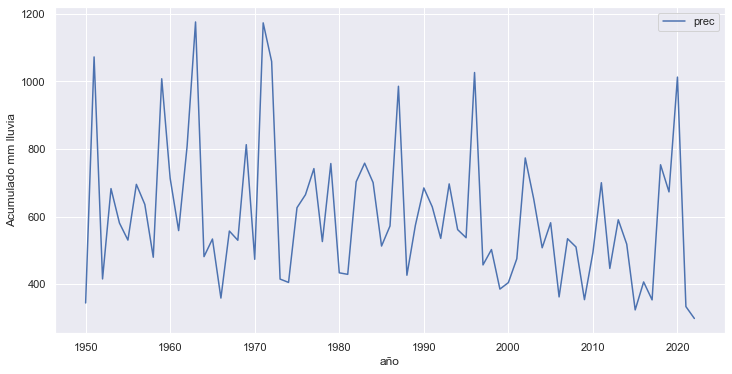

In [9]:
sns.set(font_scale=1)
fig9=plt.figure(figsize=(12,6))
ax9=plt.subplot(111)

table = datos.pivot_table(values=['prec'], index=['año'], aggfunc=np.sum, margins=True)
table = table.iloc[:-1] # Per eliminar la fila final amb el total
table.plot(ax=ax9, ylabel="Acumulado mm lluvia")

* El promig de la Temperatura Màxima durant el periode amb dades. Podem vuere que aquest promig té un valor ascendent a tots els mesos amb més o menys continuitat.

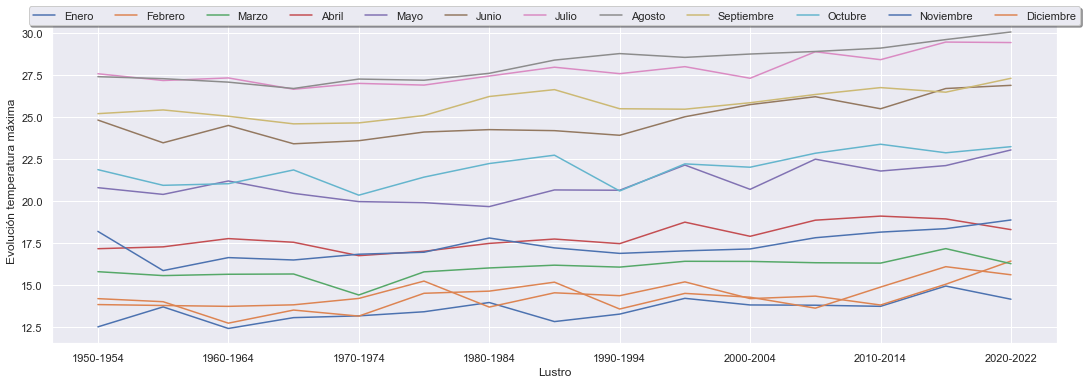

In [10]:
fig10=plt.figure(figsize=(18,6))
ax10=plt.subplot(111)
table3 = datos.pivot_table(index=['Lustro'], columns=['mes'], values=['tmax'],  aggfunc='mean')
table3.columns=['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

table3.plot(ax=ax10, ylabel="Evolución temperatura máxima")
plt.legend(loc = 'upper center', bbox_to_anchor=(0.5, 1.05), ncol=12, fancybox=True, shadow=True)

* Representem la distribució de temperatures màximes, mínimes i mitjanes, distribuits per lustres i veiem que la tendència a totes tres és de pujada.

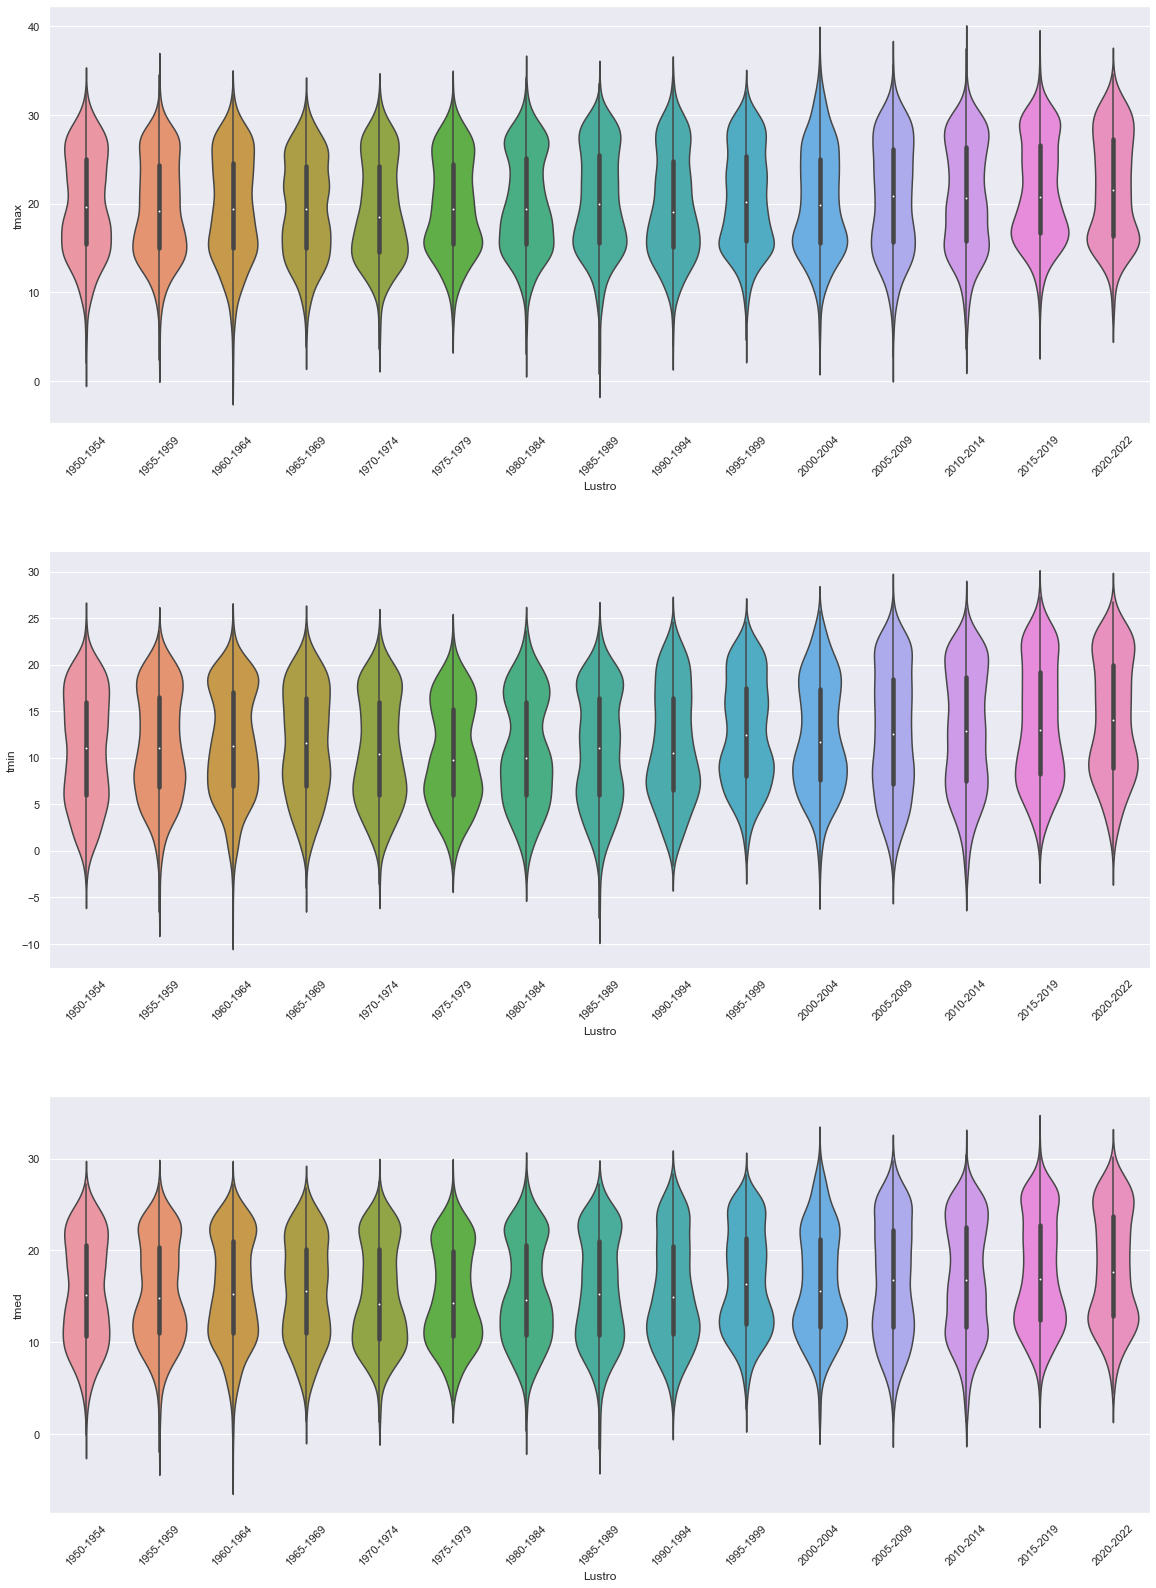

In [11]:
# representem gràficament els valors de temp màxima, mínima i mitjana per blocs de 5 anys
columns_plot = ['tmax', 'tmin', 'tmed']

fig, axs = plt.subplots(ncols=1, nrows=3,figsize=(16, 22))
#ax.yaxis.set_major_formatter(ticker.EngFormatter())
index = 0
for each in columns_plot:
    sns.violinplot(data=datos, x='Lustro', y=each, ax=axs[index])
    axs[index].set_xticklabels(axs[index].get_xticklabels(),rotation=45)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

* Fem una versió reduida del dataset per acabar d'analitzar les dades.

In [12]:
datos_modelo=datos[['prec', 'tmin', 'tmax', 'sol', 'dir', 'velmedia', 'racha', 'presMax', 'presMin', 'año', 'mes', 'tmed']]

In [13]:
datos_modelo.isnull().sum()

prec         102
tmin          69
tmax          68
sol         2187
dir         5329
velmedia    4143
racha       5331
presMax     4207
presMin     4300
año            0
mes            0
tmed          70
dtype: int64

In [14]:
#Eliminem les dades nules abans de seguir
datos_modelo.dropna(inplace=True)
datos_modelo.isnull().sum()

prec        0
tmin        0
tmax        0
sol         0
dir         0
velmedia    0
racha       0
presMax     0
presMin     0
año         0
mes         0
tmed        0
dtype: int64

In [15]:
correlacio=datos_modelo.corr().round(4)
correlacio

,prec,tmin,tmax,sol,dir,velmedia,racha,presMax,presMin,año,mes,tmed
prec,1.0000,0.0227,-0.0596,-0.2691,-0.0712,0.0678,0.1654,-0.1534,-0.1698,-0.0229,0.0422,-0.0177
tmin,0.0227,1.0000,0.9254,0.2928,-0.0293,0.0478,-0.0778,-0.1818,-0.0585,0.1714,0.2761,0.9822
tmax,-0.0596,0.9254,1.0000,0.4743,-0.0128,0.0287,-0.0948,-0.1179,0.0059,0.1254,0.2810,0.9801
sol,-0.2691,0.2928,0.4743,1.0000,0.0373,0.0638,-0.1039,0.1045,0.1813,-0.0161,-0.0481,0.3884
dir,-0.0712,-0.0293,-0.0128,0.0373,1.0000,0.0120,-0.0534,0.0804,0.0572,0.3155,0.0086,-0.0217
velmedia,0.0678,0.0478,0.0287,0.0638,0.0120,1.0000,0.6357,-0.1225,-0.1681,0.1599,-0.0818,0.0392
racha,0.1654,-0.0778,-0.0948,-0.1039,-0.0534,0.6357,1.0000,-0.1994,-0.2935,0.1331,-0.0568,-0.0877
presMax,-0.1534,-0.1818,-0.1179,0.1045,0.0804,-0.1225,-0.1994,1.0000,0.9235,0.0580,-0.0164,-0.1536
presMin,-0.1698,-0.0585,0.0059,0.1813,0.0572,-0.1681,-0.2935,0.9235,1.0000,0.0239,0.0120,-0.0276
año,-0.0229,0.1714,0.1254,-0.0161,0.3155,0.1599,0.1331,0.0580,0.0239,1.0000,-0.0129,0.1519


Text(0.5, 1.0, 'Matriu de Correl.lació')

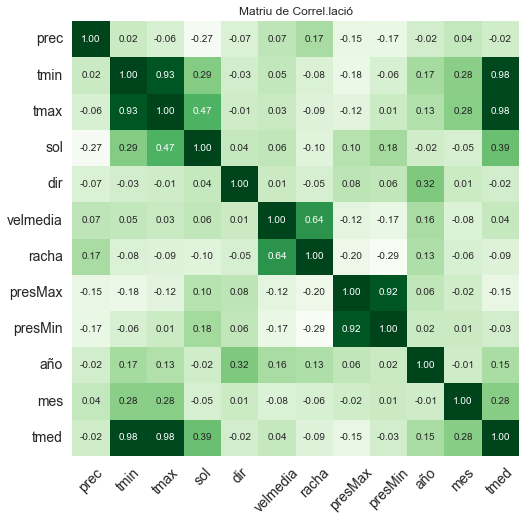

In [16]:
corr_tot = datos_modelo.corr().round(4)

f, axes = plt.subplots(1, 1, figsize=(8, 8))

ax0=sns.heatmap(corr_tot, fmt='.2f', annot=True, cbar=False, annot_kws={'size':10}, cmap='Greens', ax=axes)
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=45, fontsize=14)
ax0.set_yticklabels(ax0.get_yticklabels(),rotation=0, fontsize=14)
ax0.set_title("Matriu de Correl.lació")


* Fem servir el RandomForest per detectar els camps més importants del dataframe per trobar la tmed.

In [17]:
Titulos1=datos_modelo.columns.values.tolist()

feature_names = Titulos1[1:]

X = datos_modelo.drop(['tmed'],axis=1).values
y = datos_modelo['tmed'].values
forest = RandomForestRegressor(random_state=0).fit(X, y)

In [18]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
forest_importances

tmin        0.000007
tmax        0.845752
sol         0.154124
dir         0.000015
velmedia    0.000016
racha       0.000014
presMax     0.000016
presMin     0.000016
año         0.000015
mes         0.000017
tmed        0.000008
dtype: float64

Text(0, 0.5, 'Mean decrease in impurity')

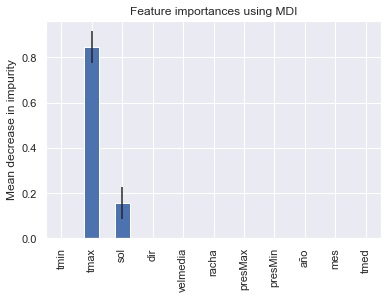

In [19]:
sns.set(font_scale=1)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

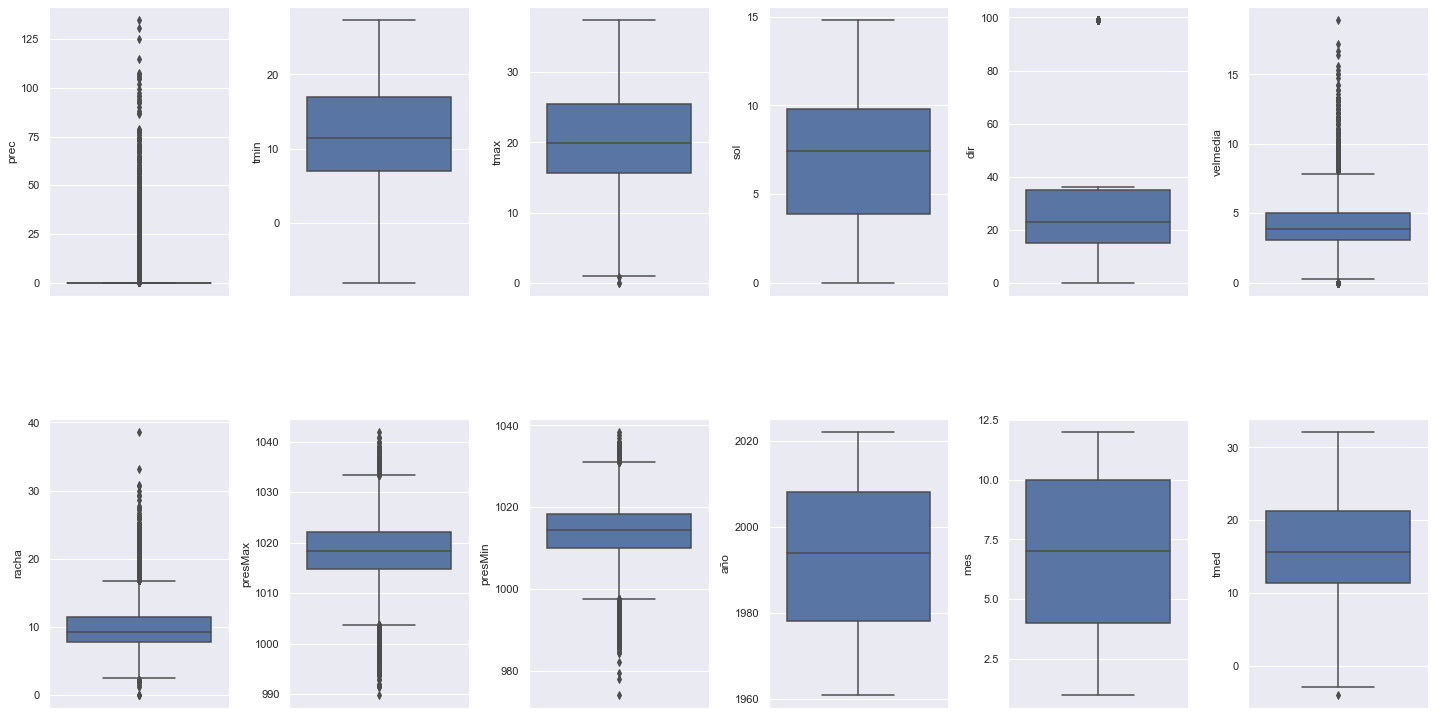

In [20]:
fig, axs = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
sns.set(font_scale=2)

for k,v in datos_modelo.items():
    sns.boxplot(y=k, data=datos_modelo, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

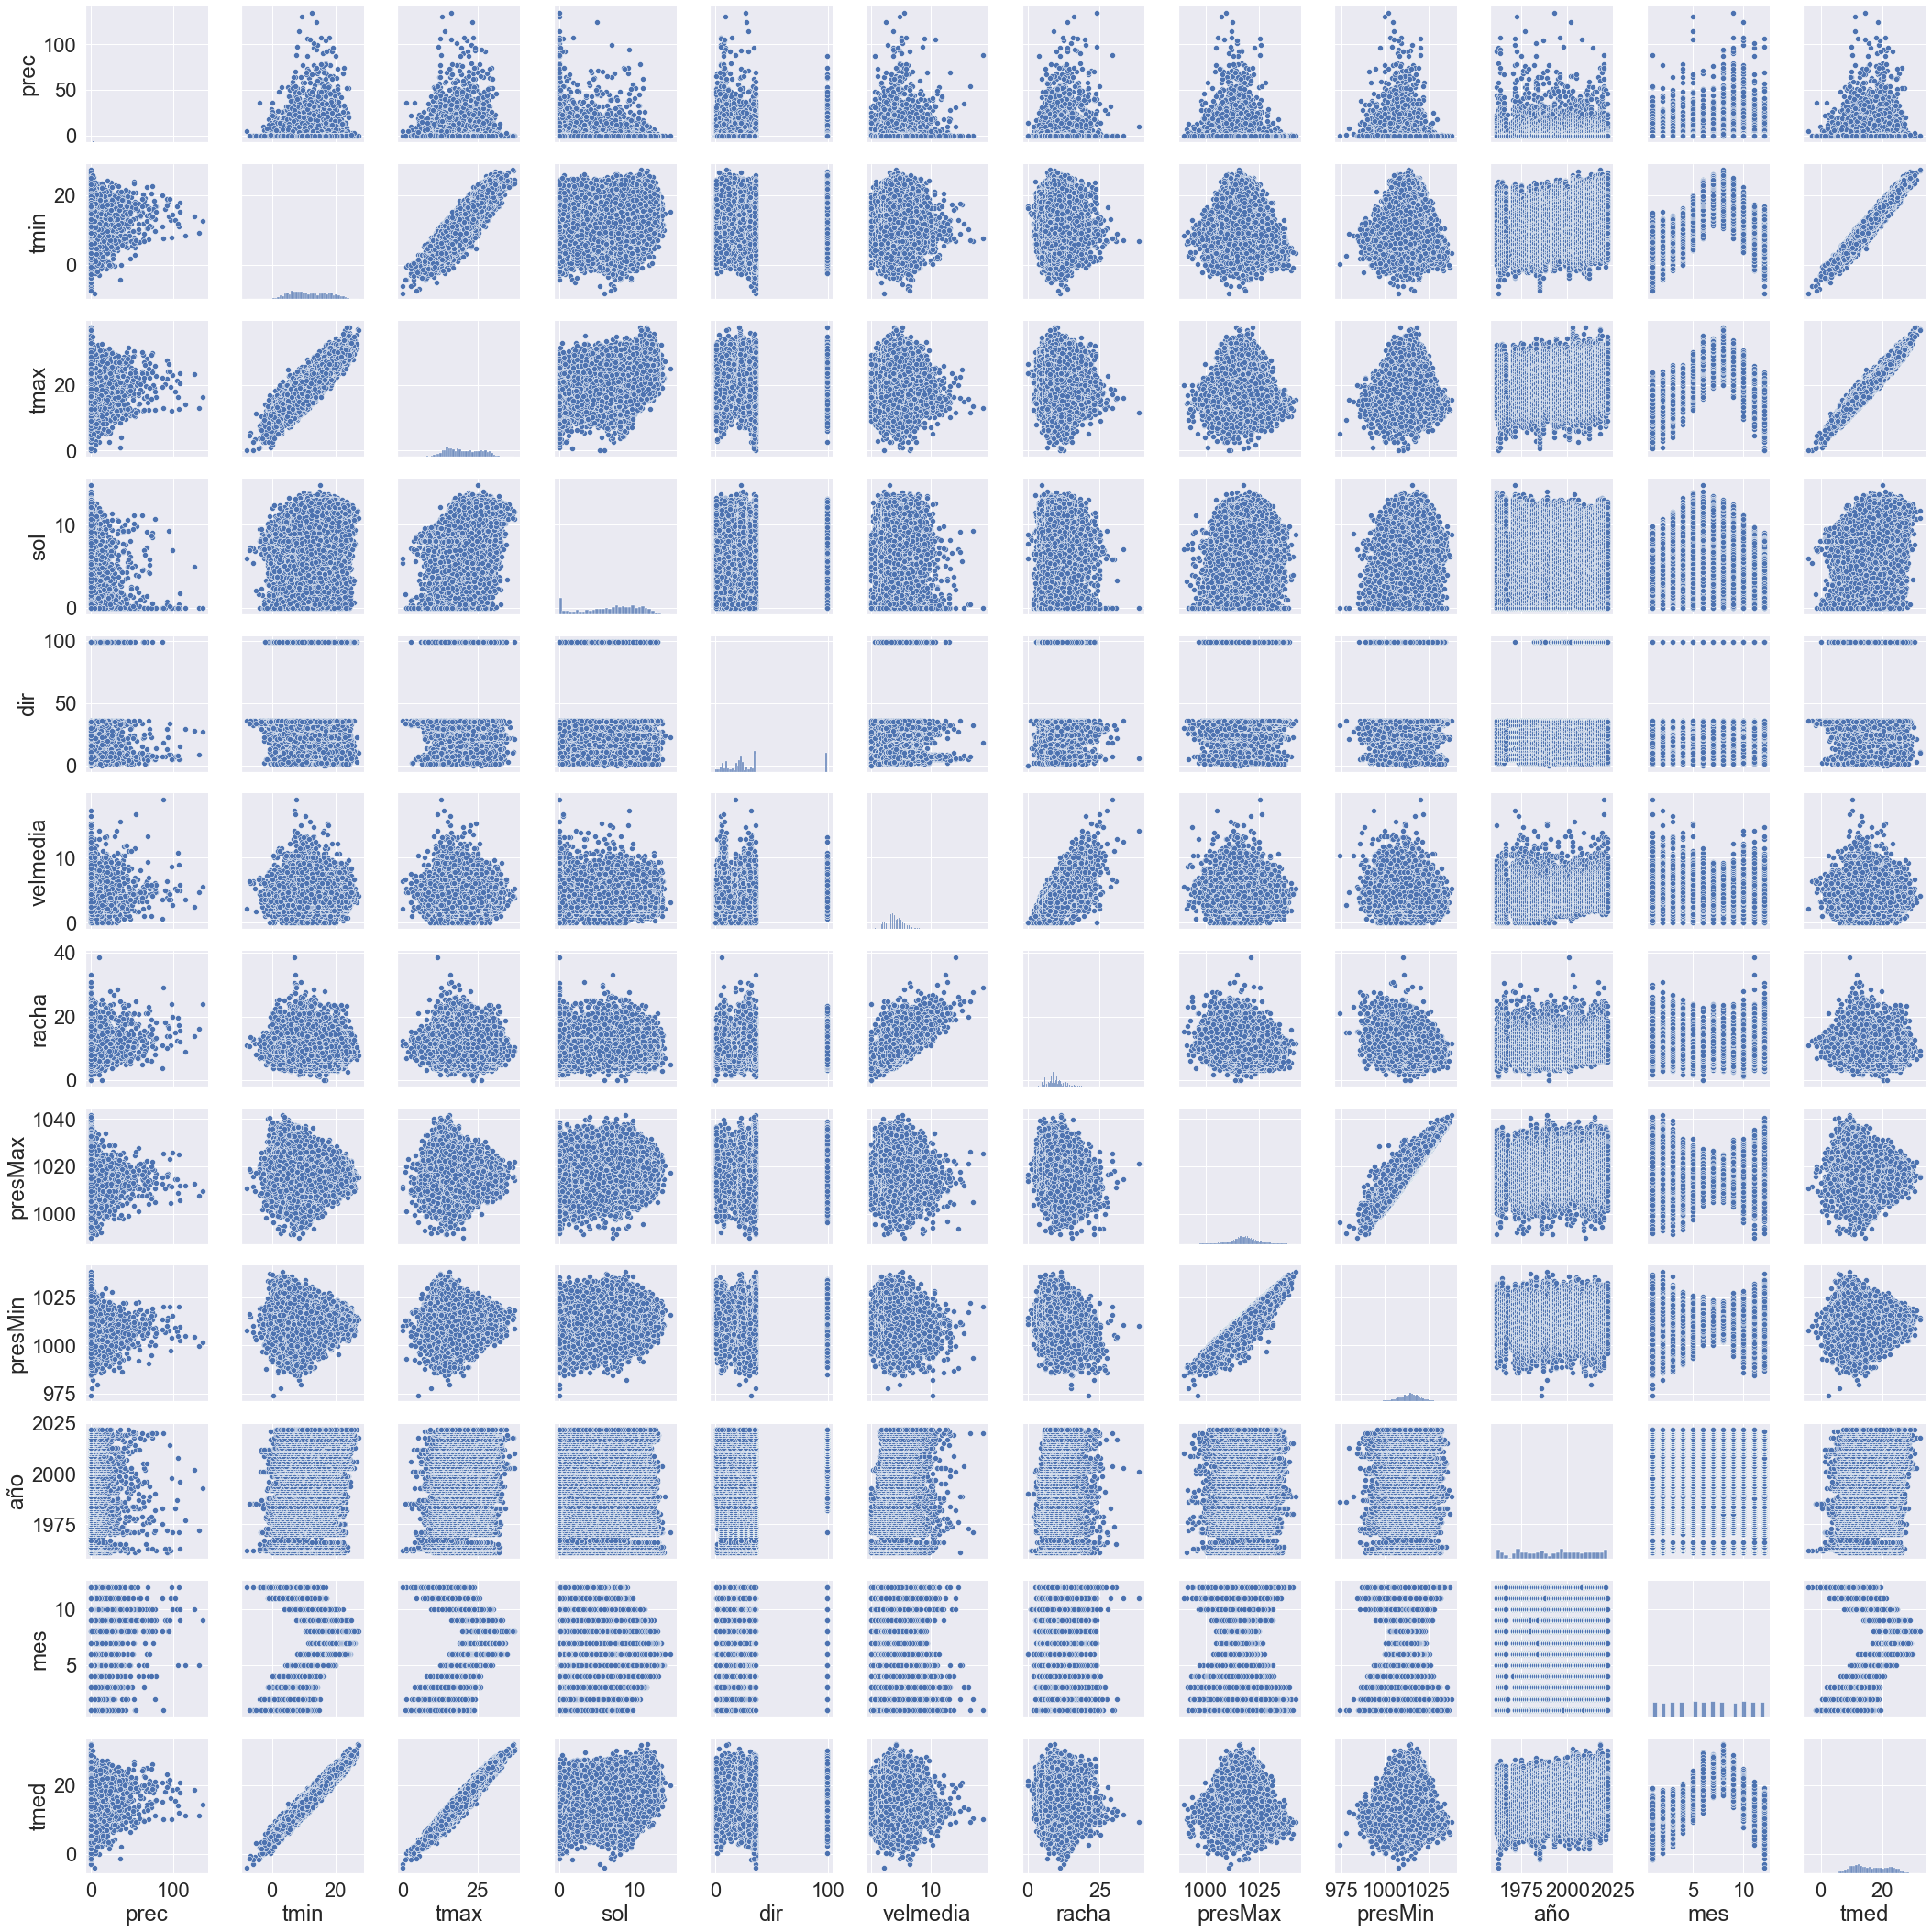

In [21]:
sns.pairplot(datos_modelo)

* Un cop analitzades les dades, veiem que els camps més representatius per predir la temperatura mitjana són: la temperatura mínima, la temperatura máxima i el sol. Pert tant fem els càlculs només tenint en conte aquests camps. Aprofitem també aquesta reducció del dataset per fer un scalat de les dades.

# Model de Regressió per predir la temperatura mitjana

In [22]:
datos_modelo_regresion=datos[['tmin', 'tmax', 'sol', 'tmed']]
datos_modelo_regresion.dropna(inplace=True)
datos_modelo_regresion.isnull().sum()

tmin    0
tmax    0
sol     0
tmed    0
dtype: int64

In [23]:
X = datos_modelo_regresion.drop(['tmed'],axis=1).values
y = datos_modelo_regresion['tmed'].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
scaler = preprocessing.RobustScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [25]:
Titulos=datos_modelo_regresion.columns.values.tolist()

arr_datos_modelo_regresion_train_scaled=np.column_stack((X_train_scaler, y_train))
df_datos_modelo_regresion_train_scaled=pd.DataFrame(arr_datos_modelo_regresion_train_scaled, columns=Titulos)

arr_datos_modelo_regresion_test_scaled=np.column_stack((X_test_scaler, y_test))
df_datos_modelo_regresion_test_scaled=pd.DataFrame(arr_datos_modelo_regresion_test_scaled, columns=Titulos)

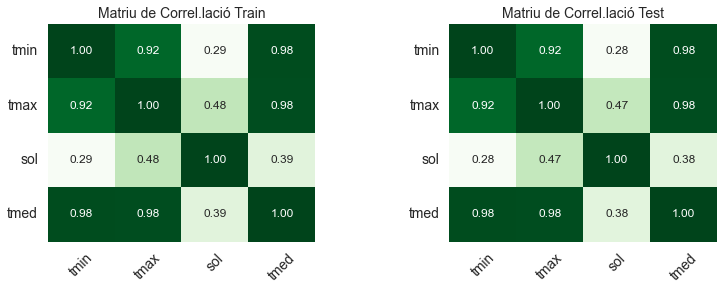

In [26]:
corr_train_regresion = df_datos_modelo_regresion_train_scaled.corr().round(4)
corr_test_regresion = df_datos_modelo_regresion_test_scaled.corr().round(4)

f, axes = plt.subplots(1, 2, figsize=(12, 4))

ax0=sns.heatmap(corr_train_regresion, fmt='.2f', annot=True, cbar=False, annot_kws={'size':12}, cmap='Greens', ax=axes[0])
ax0.set_xticklabels(ax0.get_xticklabels(),rotation=45, fontsize=14)
ax0.set_yticklabels(ax0.get_yticklabels(),rotation=0, fontsize=14)
ax0.set_title("Matriu de Correl.lació Train", fontsize=14)

ax1=sns.heatmap(corr_test_regresion, fmt='.2f', annot=True, cbar=False,annot_kws={'size':12}, cmap='Greens', ax=axes[1])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45, fontsize=14)
ax1.set_yticklabels(ax1.get_yticklabels(),rotation=0, fontsize=14)
ax1.set_title("Matriu de Correl.lació Test", fontsize=14)

# plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

Fem servir 5 models de Regressió amb GridSearch per veure quin d'ells té millor comportament en base als seus valors de R2 i MSE.

In [27]:
# Aplicarem el Grid Search per cadascun dels 5 models de regressió que estem probant.
# Multiple Linear Regression
parameters_LR = {
            'normalize': [True, False],
            'fit_intercept': [True, False],
            'positive': [True, False]
            }
LR=LinearRegression()

grid_search_LR = GridSearchCV(LR, parameters_LR, scoring='r2', cv=5)
grid_search_LR.fit(X_train_scaler, y_train)
Y_test_predict_GS_LR = grid_search_LR.predict(X_test_scaler)

In [28]:
# Polynomial Regression
poly=PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train_scaler) # Primer fem la transformació polinòmica
X_poly_test = poly.fit_transform(X_test_scaler) # També tranformem les dades de test 

parameters_PR = {
            'normalize': [True, False],
            'fit_intercept': [True, False],
            'positive': [True, False]
            }
PR=LinearRegression()

grid_search_PR = GridSearchCV(PR, parameters_PR, scoring='r2', cv=5)
grid_search_PR.fit(X_poly_train, y_train)
Y_test_predict_GS_PR = grid_search_PR.predict(X_poly_test)

In [29]:
# Decission Tree
parameters_DT = {
                "criterion": ['squared_error', 'friedman_mse', 'poisson'],
                "splitter": ["best", "random"],
                "max_depth": range(1,8,1),
                "min_samples_split": range(2,11,1),
                "min_samples_leaf": range(1,30,5),
                }
DT=DecisionTreeRegressor(random_state = 0) #Fem servir la mateixa semilla que els anteriors

grid_search_DT = GridSearchCV(DT, parameters_DT, scoring='r2', cv=5)
grid_search_DT.fit(X_train_scaler, y_train)
Y_test_predict_GS_DT = grid_search_DT.predict(X_test_scaler)

In [30]:
# Random Forest
parameters_RF = {
                "max_depth": [3, None],
                "max_features": range(1,11,1),
                "min_samples_split": range(2,11,1),
                }
RF=RandomForestRegressor(random_state = 42)

grid_search_RF = GridSearchCV(RF, parameters_RF, scoring='r2', cv=5)
grid_search_RF.fit(X_train_scaler, y_train)
Y_test_predict_GS_RF = grid_search_RF.predict(X_test_scaler)

In [31]:
# Neural Network
parameters_NN = {
#                 "hidden_layer_sizes": [(50,50,50), (50,100,50), (100,1)], 
                "activation": ["identity", "logistic", "tanh", "relu"], 
                "solver": ["lbfgs", "sgd", "adam"], 
                "alpha": [0.00005,0.0005, 0.0001],
                "learning_rate": ['constant', 'invscaling', 'adaptive'],
                "warm_start" : [True, False]
                }

NN=MLPRegressor(random_state = 0, max_iter=1000)

grid_search_NN = GridSearchCV(NN, parameters_NN, scoring='r2', cv=5, n_jobs=-1)
grid_search_NN.fit(X_train_scaler, y_train)
Y_test_predict_GS_NN = grid_search_NN.predict(X_test_scaler)

In [32]:
print("Test Set Regression Models Performance applying GridSearchCV:\n")

print("** MSE (Mean Squared Error) **:")
print("Multiple Linear Regression GS: ", mean_squared_error(y_test, Y_test_predict_GS_LR).round(4))
print("Polynomial Regression GS: ", mean_squared_error(y_test, Y_test_predict_GS_PR).round(4))
print("Decission Tree GS: ", mean_squared_error(y_test, Y_test_predict_GS_DT).round(4))
print("Random Forest GS: ", mean_squared_error(y_test, Y_test_predict_GS_RF).round(4))
print("Neural Network: ", mean_squared_error(y_test, Y_test_predict_GS_NN).round(4))

print("\n** R2 (Coefficient of determination) **:")
print("Multiple Linear Regression GS: ",grid_search_LR.score(X_test, y_test).round(4))
print("Polynomial Regression GS: ",grid_search_PR.score(X_poly_test, y_test).round(4))
print("Decission Tree GS: ",grid_search_DT.score(X_test, y_test).round(4))
print("Random Forest GS: ",grid_search_RF.score(X_test, y_test).round(4))
print("Neural Network: ",grid_search_NN.score(X_test, y_test).round(4))

Test Set Regression Models Performance applying GridSearchCV:

** MSE (Mean Squared Error) **:
Multiple Linear Regression GS:  0.0007
Polynomial Regression GS:  0.0007
Decission Tree GS:  0.1116
Random Forest GS:  0.0022
Neural Network:  0.0007

** R2 (Coefficient of determination) **:
Multiple Linear Regression GS:  -780.4781
Polynomial Regression GS:  1.0
Decission Tree GS:  -5.1768
Random Forest GS:  -6.6699
Neural Network:  -780.4847


# Model de classificació per saber si plourà o no en funció de la resta de paràmetres

Agrupem les dades històriques de precipitacions per poder fer després la classificiació més fàcilment:
* 0: si no hi ha hagut cap precipitació o ha siguit 0.05(Ip)
* 1: si la precipitació ha sigut major de 0.05


In [33]:
datos_modelo_clasificacion=datos[['prec', 'tmin', 'tmax', 'sol', 'dir', 'velmedia', 'presMax', 'presMin', 'mes', 'tmed']]
datos_modelo_clasificacion.dropna(inplace=True)
datos_modelo_clasificacion.isnull().sum()

prec        0
tmin        0
tmax        0
sol         0
dir         0
velmedia    0
presMax     0
presMin     0
mes         0
tmed        0
dtype: int64

In [34]:
datos_modelo_clasificacion['prec_clas']=datos_modelo_clasificacion['prec'].apply(lambda x: 1 if x > 0.05 else 0)
datos_modelo_clasificacion.drop(columns=['prec'], inplace=True)

In [35]:
datos_modelo_clasificacion.shape

(19493, 10)

In [36]:
Titulos2=datos_modelo_clasificacion.columns.values.tolist()

feature_names = Titulos2[1:]

X_1 = datos_modelo_clasificacion.drop(['prec_clas'],axis=1).values
y_1 = datos_modelo_clasificacion['prec_clas'].values
forest_c = RandomForestClassifier(random_state=0).fit(X_1, y_1)

In [37]:
importances_c = forest_c.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances_2 = pd.Series(importances_c, index=feature_names)
forest_importances_2

tmax         0.094242
sol          0.093731
dir          0.257827
velmedia     0.089877
presMax      0.078336
presMin      0.114886
mes          0.138053
tmed         0.045659
prec_clas    0.087389
dtype: float64

Text(0, 0.5, 'Mean decrease in impurity')

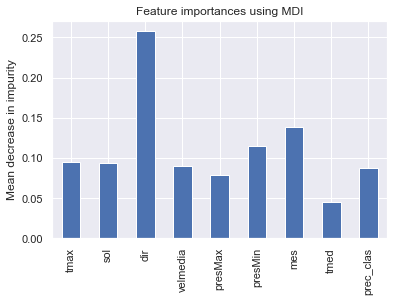

In [38]:
sns.set(font_scale=1)

fig, ax22 = plt.subplots()
forest_importances_2.plot.bar( ax=ax22)
ax22.set_title("Feature importances using MDI")
ax22.set_ylabel("Mean decrease in impurity")

In [39]:
from datetime import datetime

Fechalreves=str(datetime.now().year) + str(datetime.now().month)+ str(datetime.now().day)
datos_modelo_clasificacion.to_excel("Prueba datos climatológicos aeropuerto de Barcelona (classificación)-"+Fechalreves+".xlsx")

In [40]:
datos_modelo_clasificacion.head()

,tmin,tmax,sol,dir,velmedia,presMax,presMin,mes,tmed,prec_clas
4018,7.0,10.0,0.0,36.0,1.4,1017.5,1011.0,1,8.5,1
4019,5.0,13.8,7.2,29.0,4.4,1019.2,1016.2,1,9.4,0
4020,9.4,14.6,2.5,32.0,5.3,1013.8,999.9,1,12.0,0
4021,8.8,12.0,4.5,32.0,9.7,1008.6,1003.2,1,10.4,0
4022,4.0,11.4,8.0,36.0,3.1,1022.2,1010.7,1,7.7,0


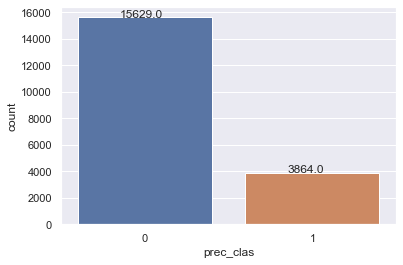

In [41]:
sns.set(font_scale=1)
ax4=sns.countplot(x=datos_modelo_clasificacion['prec_clas'])
for p in ax4.patches:
    ax4.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [42]:
# Aplicarem el Grid Search per cadascun dels 5 models de clasificació que estem probant.
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [43]:
X_c = datos_modelo_clasificacion.drop(['prec_clas'],axis=1).values
y_c = datos_modelo_clasificacion['prec_clas'].values
X_train_c, X_test_c, y_train_c ,y_test_c = train_test_split(X_c, y_c, test_size=0.3, random_state=0)

scaler = preprocessing.RobustScaler()

X_train_c_scaler = scaler.fit_transform(X_train_c)
X_test_c_scaler = scaler.transform(X_test_c)

In [44]:
# Decission Tree
parameters_DT = {
            'criterion': ['gini', 'entropy'],
            'splitter': ["best", "random"],
            'max_depth': range(1,15,1),
            'min_samples_split': range(2,200,20),
            'min_samples_leaf': range(1,60,10),
            }
DT=DecisionTreeClassifier(random_state=0)

grid_search_DT = GridSearchCV(DT, parameters_DT, scoring='accuracy', cv=10).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_DT = grid_search_DT.predict(X_test_c_scaler)
Y_test_prob_GS_DT = grid_search_DT.predict_proba(X_test_c_scaler)

In [45]:
# K-nearest Neighbors (KNN)
parameters_KN = {
            'n_neighbors': range(1,15,2),
            'weights':['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute'],
            'leaf_size': range(1,50,5)
            }
KN=KNeighborsClassifier()

grid_search_KN = GridSearchCV(KN, parameters_KN, scoring='accuracy', cv=10).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_KN = grid_search_KN.predict(X_test_c_scaler)
Y_test_prob_GS_KN = grid_search_KN.predict_proba(X_test_c_scaler)

KN_best=KNeighborsClassifier(**grid_search_KN.best_params_).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_KN_best = KN_best.predict(X_test_c_scaler)
Y_test_prob_GS_KN_best = KN_best.predict_proba(X_test_c_scaler)


In [46]:
# Support Vector Machines (SVM)
parameters_SVM = {
                'gamma': ['auto'],
                'kernel': ['rbf', 'linear', 'poly'],
                'degree':[2,3,4],
                'probability': [True]
                 }
SVM=svm.SVC( probability=True)

grid_search_SVM = GridSearchCV(SVM, parameters_SVM, scoring='accuracy', cv=10).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_SVM = grid_search_SVM.predict(X_test_c_scaler)
Y_test_prob_GS_SVM = grid_search_SVM.predict_proba(X_test_c_scaler)

SVM_best=svm.SVC(**grid_search_SVM.best_params_).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_SVM_best = SVM_best.predict(X_test_c_scaler)
Y_test_prob_GS_SVM_best = SVM_best.predict_proba(X_test_c_scaler)


In [47]:
# XGBoost
parameters_XGB = {
                    'max_depth': range (2, 10, 1),
                    'n_estimators': range(60, 220, 40),
                    'learning_rate': [0.1, 0.01, 0.05]
                 }
XGB=xgb.XGBClassifier().fit(X_train_c_scaler, y_train_c)

grid_search_XGB = GridSearchCV(XGB, parameters_XGB, scoring='accuracy', cv=10).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_XGB = grid_search_XGB.predict(X_test_c_scaler)
Y_test_prob_GS_XGB = grid_search_XGB.predict_proba(X_test_c_scaler)

XGB_best=xgb.XGBClassifier(**grid_search_XGB.best_params_).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_XGB_best = XGB_best.predict(X_test_c_scaler)
Y_test_prob_GS_XGB_best = XGB_best.predict_proba(X_test_c_scaler)


In [48]:
# Logistic Regression
parameters_LR = {
                 'max_iter': range (100, 5000, 500),
                 'penalty':['l1', 'l2', 'elasticnet', 'none'],
                 'dual':[True, False],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                 }
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")


class_LR = LogisticRegression(random_state=16).fit(X_train_c_scaler, y_train_c)
y_pred_test_LR = class_LR.predict(X_test_c_scaler)
y_prob_test_LR = class_LR.predict_proba(X_test_c_scaler)

grid_search_LR = GridSearchCV(class_LR, parameters_LR, scoring='accuracy', cv=10).fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_LR = grid_search_LR.predict(X_test_c_scaler)
Y_test_prob_GS_LR = grid_search_LR.predict_proba(X_test_c_scaler)

LR_best = LogisticRegression(**grid_search_LR.best_params_)
LR_best.fit(X_train_c_scaler, y_train_c)
Y_test_pred_GS_LR_best = LR_best.predict(X_test_c_scaler)
Y_test_prob_GS_LR_best = LR_best.predict_proba(X_test_c_scaler)


In [49]:
# Test Set Classification Models Performance
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, recall_score, precision_score, roc_auc_score

def funcio_metriques2(y_t, codi, probs, titols): #Fem una funció per poder fer-la servir als següents exercicis
    metriques_titol=['Accuracy', 'f1_Score (weighted)', 'Precission (weighted)', 'Recall (weighted)', 
    'f1_Score (macro)','Precission (macro)', 'Recall (macro)', 'f1_Score (micro)', 'Precission (micro)', 'Recall (micro)']
    averages=['weighted','macro', 'micro']
    metriques=np.zeros((len(metriques_titol),len(codi))) #inicialitzem l'arry amb zeros

    for j in range(len(codi)): # Omplim les columnes
            z=0
            metriques[0,j]=accuracy_score(y_t, codi[j]).round(4) # Accuracy: Millor contra més a prop del 1
#             metriques[1,j]=roc_auc_score(y_t, probs[j], multi_class='ovo').round(4) # ROC_AUC: Millor contra més a prop del 1
            
            for i in range(len(averages)):
                z=i*3
                metriques[1+z,j]=f1_score(y_t, codi[j], average=averages[i]).round(4)
                metriques[2+z,j]=precision_score(y_t, codi[j], average=averages[i]).round(4)
                metriques[3+z,j]=recall_score(y_t, codi[j], average=averages[i]).round(4)

    metrics_df = pd.DataFrame( data = metriques, columns = titols, index=metriques_titol)
    return metrics_df

In [50]:
prediccions_codi=[Y_test_pred_GS_DT, Y_test_pred_GS_KN, Y_test_pred_GS_SVM, Y_test_pred_GS_XGB, Y_test_pred_GS_LR ]
probabilitats_codi=[Y_test_prob_GS_DT,Y_test_prob_GS_KN, Y_test_prob_GS_SVM, Y_test_prob_GS_XGB, Y_test_prob_GS_LR ]
prediccions_titol=['Decission Tree_GS','KNN_GS', 'SVM_GS', 'XGB_GS', 'LR_GS']

funcio_metriques2(y_test_c, prediccions_codi, probabilitats_codi, prediccions_titol).T

,Accuracy,f1_Score (weighted),Precission (weighted),Recall (weighted),f1_Score (macro),Precission (macro),Recall (macro),f1_Score (micro),Precission (micro),Recall (micro)
Decission Tree_GS,0.8369,0.8227,0.8215,0.8369,0.7064,0.7583,0.6814,0.8369,0.8369,0.8369
KNN_GS,0.8370,0.8199,0.8209,0.8370,0.6984,0.7636,0.6712,0.8370,0.8370,0.8370
SVM_GS,0.8429,0.8199,0.8303,0.8429,0.6914,0.7953,0.6594,0.8429,0.8429,0.8429
XGB_GS,0.8466,0.8308,0.8334,0.8466,0.7168,0.7857,0.6869,0.8466,0.8466,0.8466
LR_GS,0.8461,0.8316,0.8327,0.8461,0.7198,0.7811,0.6913,0.8461,0.8461,0.8461


****************************************** Confussion Matrix ******************************************


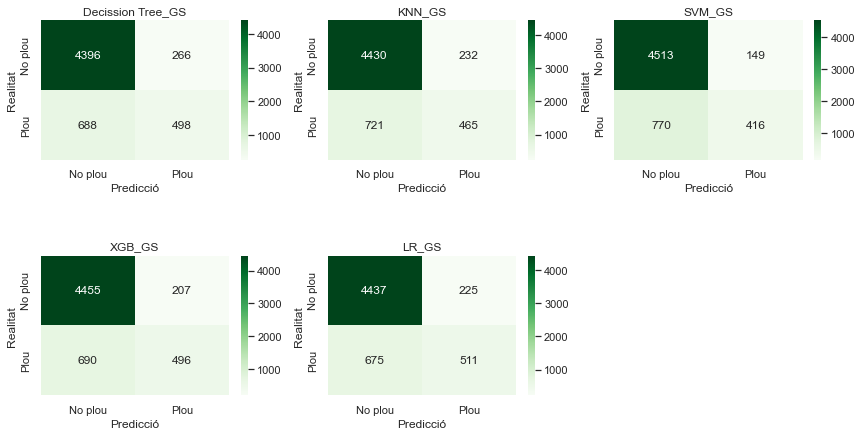

In [52]:
print("****************************************** Confussion Matrix ******************************************")
classes_names = ['No plou','Plou']
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12,6))
index = 0
axs = axs.flatten()

for i in range(len(prediccions_codi)):
    cm = pd.DataFrame(confusion_matrix(y_test_c, prediccions_codi[i]), columns=classes_names, index = classes_names)
    ax=sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axs[index]) # Seaborn's heatmap to better visualize the confusion matrix
    ax.set(xlabel='Predicció', ylabel='Realitat')
    ax.set_title(prediccions_titol[i])    
    index += 1
axs[5].axis('off') #Esborrem els exios de l'últim gràfic

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=4.0)
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)